# Sentiment Analysis 2 - PyTorch

## 0. Setup

In [2]:
# General packages
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random
import bcolz
import pickle

# NLP packages
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling packages
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from src.text_classifiers import RNNClassifier, initialize_weights
from src.tripadvisor_dataset import SentimentDataset, collate
from src.utils import calc_distr, parse_glove


%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize

# for auto-reloading external modules see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Parameters

In [3]:
params={
    'SEED': 123,            # seed for random processes                 
    'max_features': 20000,  # vocabulary size
    'embedding_dim': 256,   # size of an embedding vector (if not using pretrained embedding vectors)
    'hidden_size': 512,     # number of features in the hidden state of the rnn layer
    'rnn_type': 'gru',      # use 'rnn', 'lstm' or 'gru'
    'bidirectional': False,  # If True, use bidirectional rnn 
    'n_layers': 5,          # number of layers in the stacked rnn 
    'dropout': 0.5,         # if non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer
    'output_size': 3,       # number of classes
    'gclip': 40,            # To tackle the exploding gradient problem, set gclip and use clip_grad_norm_(X, gclip)
    'batch_size': 128,       # Batch size for stochastic gradient descent
    'lr': 5e-4,             # Learning rate for the Adam optimizer
    'lr_decay': 0.5,       # Learning rate decay parameter for ReduceLROnPlateau
    'epochs': 100,           # Number of epochs to train the model
    'print_every': None,    # Frequency of printing the loss in an epoch
    'patience': 10,          # Patience value used for early stopping if the performance does not increase.
    'weighted_loss': True,  # Use a weighted Cross Entropy Loss function to balance classes
    'pretrained_embedding': None    # Use pretrained embedding vectors, otherwise train from scratch. Can be 50, 100, 200, 300 or None
}

## 1. Dataset
### Load Data

In [4]:
data_root = os.path.join(os.path.abspath(os.getcwd()), "data", "tripadvisor_hotel_reviews_preproc.csv")
data = pd.read_csv(data_root)
data.head()

,Review,Rating,Review_preprocessed,Sentiment_rating
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,1
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,2
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,2


### Create Vocabulary

Build a vocabulary that only consider the top `max_features` ordered by term frequency across the corpus.

In [5]:

tfidfconverter = TfidfVectorizer(use_idf=True, max_features=params['max_features'], min_df=0, max_df=1.0)
tfidfconverter.fit_transform(data['Review_preprocessed'])
pre_vocab = tfidfconverter.vocabulary_

In [6]:
print('Vocabulary size:', len(pre_vocab), '\n\n  Sample words\n{}'.format('-' * 20))
sample_words = random.sample(list(pre_vocab.keys()), 10)
for word in sample_words:
    print(' {}'.format(word))

Vocabulary size: 20000 

  Sample words
--------------------
 manditory
 confined
 totalled
 stop
 sail
 overhearing
 sixth
 whenyou
 capture
 pooch


In addition to the words that appear in our data, we need to have two special words:

- `<eos>` End of sequence symbol used for padding
- `<unk>` Words unknown in our vocabulary

In [7]:
vocab = {'<eos>': 0, '<unk>': 1}
for key in pre_vocab.keys():
    vocab[key] = len(vocab)
print('Vocabulary size:', len(vocab))
# for i in range(len(vocab)-50, len(vocab)):
#     print(list(vocab.keys())[list(vocab.values()).index(i)])

Vocabulary size: 20002


### Create Dataset

Steps:
* Tokenize data
* Create index-label pairs based on vocabulary
* Divide into train, validation and test sets
* Wrapping to PyTorch dataset


In [8]:
tokenized_data = []
for i in range(len(data)):
    tokenized_data.append((nltk.word_tokenize(data['Review_preprocessed'][i]), data['Sentiment_rating'][i]))
print(tokenized_data[-1])    

(['people', 'talking', 'ca', 'believe', 'excellent', 'rating', 'hotel', 'yes', 'patricia', 'extremely', 'helpful', 'fluent', 'language', 'go', 'way', 'make', 'welcome', 'said', 'place', 'bit', 'dump', 'inexpensive', 'hotel', 'expensive', 'city', 'place', 'bit', 'dated', 'institutional', 'odor', 'charm', 'funeral', 'home', 'walking', 'step', 'hotel', 'girlfriend', 'step', 'condom', 'yes', 'condom', 'step', 'lot', 'guy', 'hanging', 'desk', 'hallway', 'girlfriend', 'swears', 'house', 'prostitution', 'patricia', 'arrange', 'taxi', 'following', 'morning', 'stayed', 'night', 'wrong', 'information', 'cost', 'fare', 'room', 'clean', 'large', 'bathroom', 'small', 'passable', 'night', 'glad', 'leave', 'following', 'morning', 'recommend', 'extended', 'stay', 'unless', 'tight', 'budget', 'care', 'look', 'feel', 'place'], 0)


In [9]:
indexed_data = []
for tokens, label in tokenized_data:
    indices = [vocab.get(token, vocab['<unk>']) for token in tokens]    
    # the token that is not in vocab get assigned <unk>
    indexed_data.append((indices, label))
print(indexed_data[-1])    

([49, 50, 639, 1415, 324, 1323, 3, 971, 12658, 791, 148, 11451, 390, 1660, 284, 177, 479, 98, 449, 972, 2149, 2883, 3, 4, 393, 449, 972, 2828, 12714, 2136, 601, 13212, 571, 66, 1202, 3, 385, 1202, 6781, 971, 6781, 1202, 552, 2119, 1364, 96, 51, 385, 1, 436, 11113, 12658, 252, 373, 1037, 42, 456, 41, 905, 1754, 804, 1099, 27, 28, 219, 92, 549, 6704, 41, 2676, 415, 1037, 42, 450, 2219, 9, 853, 2062, 1360, 839, 298, 361, 449], 0)


Dataset class also reverse sorts the sequences with respect to the lengths. Thanks to this sorting, we can reduce the total number of padded elements, which means that we have less computations for padded values.

In [10]:
combined_data = [(raw_text, tokens, indices, label) for (raw_text, label), (tokens, _), (indices, _)
    in zip(list(data[['Review_preprocessed', 'Sentiment_rating']].to_records(index=False)), tokenized_data, indexed_data)]

Let's divide the dataset into train, validation and test sets (60%-20%-20%). Stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [11]:
val_test_len = int(len(combined_data) * 0.2)
train_val_data, test_data = train_test_split(combined_data,test_size=val_test_len, random_state=params['SEED'], stratify=data['Sentiment_rating'])
df = pd.DataFrame(train_val_data, columns=['raw_text', 'tokens', 'indices', 'label'])
train_data, val_data = train_test_split(train_val_data,test_size=val_test_len, random_state=params['SEED'], stratify=df['label'])

Let's check out the distribution of the classes in the created datasets.

In [12]:
print(calc_distr(combined_data))
print(calc_distr(train_val_data))
print(calc_distr(train_data))
print(calc_distr(val_data))
print(calc_distr(test_data))

{'0': 0.15684934849446097, '1': 0.4012981308867308, '2': 0.44185252061880825}
{'0': 0.15683523455133289, '1': 0.4013298359055695, '2': 0.44183492954309767}
{'0': 0.15681171207808053, '1': 0.40130134200894674, '2': 0.44188694591297273}
{'0': 0.15690580771107857, '1': 0.40141532454856027, '2': 0.44167886774036114}
{'0': 0.15690580771107857, '1': 0.4011713030746706, '2': 0.4419228892142509}


In [13]:
# Check out the number of data samples in the created datasets.
print(len(combined_data))
print(len(train_val_data))
print(len(train_data))
print(len(val_data))
print(len(test_data))

20491
16393
12295
4098
4098


Let us wrap our data in a PyTorch dataset. For more details, check out the previous notebook and the corresponding dataset class defined in `src/tripadvisor_dataset.py`.

In [14]:
#Define a Dataset Class for train, val and test set
train_dataset = SentimentDataset(train_data)
val_dataset = SentimentDataset(val_data)
test_dataset = SentimentDataset(test_data)

Note that in the dataset we created, not all sequences have the same length. Therefore, we cannot minibatch the data trivially. This means we cannot use a `DataLoader` class easily.

To solve the problem, we need to pad the sequences with <code> <eos> </code> tokens that we indexed as zero. To integrate this approach into the Pytorch <a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader" target="_blank">Dataloader</a> class, we will make use of the <code>collate_fn</code> argument. For more details, check out the <code>collate</code> function in <code>src/tripadvisor_dataset</code>.

In addition, we use the <a href="https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html" target="_blank">pad_sequence</a> that pads shorter sequences with 0.


In [15]:
loader = DataLoader(train_dataset, batch_size=3, collate_fn=collate)
for batch in loader:
    print('Data: \n', batch['data'])
    print('\nLabels: \n', batch['label'])
    print('\nSequence Lengths: \n', batch['lengths'])
    print('\n')
    break

Data: 
 tensor([[2552,  120,  176],
        [  17,   84,  158],
        [ 963,    7, 6022],
        ...,
        [  77,    0,    0],
        [ 520,    0,    0],
        [ 571,    0,    0]])

Labels: 
 tensor([1., 2., 1.])

Sequence Lengths: 
 tensor([1863, 1673, 1381])




## 2. Pre-trained GloVe embeddings

Rather than training our own word vectors from scratch, we can also leverage GloVe embeddings. Its authors have released four text files with word vectors trained on different massive web datasets. They are available for download [here](https://nlp.stanford.edu/projects/glove/). We will use `Wikipedia 2014 + Gigaword 5` which is the smallest file ([`glove.6B.zip`](http://nlp.stanford.edu/data/wordvecs/glove.6B.zip)) with 822 MB. It was trained on a corpus of 6 billion tokens and contains a vocabulary of 400 thousand tokens.

First, download `glove.6B.zip` to the `data/` folder. After unzipping the downloaded file we find four txt files: `glove.6B.50d.txt`, `glove.6B.100d.txt`, `glove.6B.200d.txt`, `glove.6B.300d.txt`. As their filenames suggests, they have vectors with different dimensions. We pick the smallest one with words represented by vectors of dim 50 (`glove.6B.50d.txt`).

Given that the vocabulary have 400k tokens, we will use `bcolz` to store the array of vectors. It provides columnar, chunked data containers that can be compressed either in-memory and on-disk. It is based on `NumPy`, and uses it as the standard data container to communicate with `bcolz` objects.

We need to parse the file to get as output: list of words, dictionary mapping each word to their id (position) and array of vectors. We then save the outputs to disk for future uses ( with the `parse_glove()` function). Using those objects we can now create a dictionary that given a word returns its vector. GloVe’s vocabulary is likely to be different from our dataset’s vocabulary. For each word in dataset’s vocabulary, we check if it is GloVe’s vocabulary. If it is, we load its pre-trained word vector. Otherwise, we initialize a random vector.

In [16]:
if params['pretrained_embedding'] is not None:
    glove_path = os.path.join(os.path.abspath(os.getcwd()), "data", "glove.6B")
    
    # uncomment this the first time you use GloVe embeddings.
    # parse_glove(glove_path=glove_path, embedding_dim=params['pretrained_embedding'])

    vectors = bcolz.open(f'{glove_path}/6B.{params["pretrained_embedding"]}.dat')[:]
    words = pickle.load(open(f'{glove_path}/6B.{params["pretrained_embedding"]}_words.pkl', 'rb'))
    word2idx = pickle.load(open(f'{glove_path}/6B.{params["pretrained_embedding"]}_idx.pkl', 'rb'))

    glove = {w: vectors[word2idx[w]] for w in words}

    matrix_len = len(vocab)
    embedding_weights = np.zeros((matrix_len, params['pretrained_embedding']))
    scale = np.std(vectors, axis=0)
    words_found = 0
    for i, word in enumerate(vocab):
        try: 
            embedding_weights[i] = glove[word]
            words_found += 1
        except KeyError:
            embedding_weights[i] = np.random.normal(scale=scale, size=(params['pretrained_embedding'], ))
    print(f"{words_found} words have been found in GloVe. For the remaining {matrix_len - words_found} words a random vector has been assigned.")
    embedding_weights = torch.from_numpy(embedding_weights)
else:
    embedding_weights = None


## 3. Creating a Sentiment Classifier

After we have loaded the data, it is time to define a model and start training and testing.

### Evaluation Metrics

Since we need to predict positive, neutral or negative, we use `cross-entropy loss` to train our model. 

We usually take *accuracy* as our metric for most classification problems, however, ratings are ordered, *RMSE* (root mean squared error) is a reasonable alternative. 

In [17]:
if params['weighted_loss']:
    loss_weights = 1/torch.Tensor(list(calc_distr(train_data).values())).cuda()
else:
    loss_weights = None

loss_fn = nn.CrossEntropyLoss(weight=loss_weights)

@torch.no_grad()
def validation_metrics (model, data_loader):
    model.eval()
    correct = np.array([0]*params['output_size'])
    total = np.array([0]*params['output_size'])
    sum_loss = 0.0
    sum_rmse = 0.0
    device = next(model.parameters()).device
    preds = []

    for i, x in enumerate(data_loader):
        input = x['data'].to(device)
        lengths = x['lengths']
        label = x['label'].to(device)
        
        pred = model(input, lengths)
        loss = loss_fn(pred, label.long())
        pred = torch.max(pred, 1)[1]
        preds.extend(pred.cpu().tolist())

        for i, y in enumerate(label.int().cpu()):
            correct[y.item()] += (pred[i].cpu() == y).float()
            total[y.item()] += 1
        sum_loss += loss.item()*label.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), label.unsqueeze(-1).cpu()))*label.shape[0]
    
    class_acc = correct / total
    return sum_loss/total.sum(), np.mean(class_acc), sum_rmse/total.sum(), preds

### Design the model

See <code>src/text_classifiers.py</code> for the implementation of the <code>RNNClassifier</code>.

In [18]:
model = RNNClassifier(num_embeddings=len(vocab), embedding_dim=params['embedding_dim'], hidden_size=params['hidden_size'], rnn_type=params['rnn_type'], 
                    bidirectional=params['bidirectional'], n_layers = params['n_layers'], dropout = params['dropout'], output_size= params['output_size'],
                    pretrained_embedding=embedding_weights)
model.apply(initialize_weights)

RNNClassifier(
  (embedding): Embedding(20002, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=5, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

### Train the model

Note the **collate function** used with the `DataLoader`.

In [19]:
# Training configs
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using {}...\n'.format(device))

# set up tensorboard storage
file_name = f"{params['rnn_type']}_{params['embedding_dim']}_{params['hidden_size']}_{params['n_layers']}_{params['lr']}"
file_name += "_bidir" if params["bidirectional"] else ""
file_name += f'_glove{params["pretrained_embedding"]}' if (params["pretrained_embedding"] is not None) else ""
dir_name = os.path.join(os.path.abspath(os.getcwd()),"tensorboard_log", file_name)
writer = SummaryWriter(log_dir=dir_name) 

# Dataloaders, note the collate function
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], collate_fn=collate, drop_last=True, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], collate_fn=collate, drop_last=False, num_workers=2)

Using cuda...



Visualize model in tensorboard.

In [20]:
# x = next(iter(train_loader))
# writer.add_graph(model=model.cpu(), input_to_model=(x['data'], x['lengths']))
# writer.close()

Training loop:

In [21]:
# Move model to the device we are using
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['lr_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=np.floor(params['patience']/2), factor=params['lr_decay'])

train_loss_history = []
val_loss_history = []
best_acc = 0
model.train()

# train for some number of epochs
for e in range(params['epochs']):
    model.train()
    sum_loss = 0.0
    total = 0

    # batch loop
    for i, x in enumerate(train_loader):
        inputs = x['data'].to(device)
        lengths = x['lengths']
        labels = x['label'].to(device)
        # zero accumulated gradients
        optimizer.zero_grad()

        # get the output from the model
        output = model(inputs, lengths)

        # calculate the loss and perform backprop
        loss = loss_fn(output, labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        clip_grad_norm_(model.parameters(), max_norm=params['gclip'])
        optimizer.step()

        sum_loss += loss.item()*x['label'].shape[0]
        total += x['label'].shape[0]
               
        # loss stats
        if (params['print_every'] is not None) and (i % params['print_every'] == 0):
            print('Step {} / {}, Loss {}'.format(i, len(train_loader), loss.item()))
    # Get validation loss
    val_loss, val_acc, val_rmse, _ = validation_metrics(model, val_loader)

    # Learning rate scheduler
    scheduler.step(val_loss)
    
    writer.add_scalar("Train Loss", sum_loss/total, e)
    writer.add_scalar("Validation Loss", val_loss, e)
    writer.add_scalar("Validation Accuracy", val_acc, e)
    writer.add_scalar("Validation RMSE", val_rmse, e)

    train_loss_history.append(sum_loss/total)
    val_loss_history.append(val_loss)

    print("Epoch: {}/{}...".format(e+1, params['epochs']),
            "Train Loss: {:.3f}...".format(sum_loss/total),
            "Val Loss: {:.3f}...".format(val_loss),
            "Val Acc: {:.3f}...".format(val_acc),
            "Val RMSE: {:.3f}".format(val_rmse))
    # Early stopping
    if val_acc > best_acc:
        pat = 0
        best_acc = val_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        best_epoch = e+1
    else:
        pat += 1

    if pat == params['patience']:
        print('Early stopping at epoch {epoch}.'.format(epoch=best_epoch))
        break
            
model.load_state_dict(best_model_weights)
torch.save(model.state_dict(), os.path.join(os.path.abspath(os.getcwd()), "saved_models", file_name+".pth"))

Epoch: 1/100... Train Loss: 1.045... Val Loss: 1.008... Val Acc: 0.478... Val RMSE: 1.100
Epoch: 2/100... Train Loss: 0.937... Val Loss: 0.987... Val Acc: 0.570... Val RMSE: 0.819
Epoch: 3/100... Train Loss: 0.918... Val Loss: 0.961... Val Acc: 0.557... Val RMSE: 0.818
Epoch: 4/100... Train Loss: 0.841... Val Loss: 0.939... Val Acc: 0.611... Val RMSE: 0.757
Epoch: 5/100... Train Loss: 0.784... Val Loss: 0.847... Val Acc: 0.607... Val RMSE: 0.737
Epoch: 6/100... Train Loss: 0.727... Val Loss: 0.848... Val Acc: 0.651... Val RMSE: 0.678
Epoch: 7/100... Train Loss: 0.668... Val Loss: 0.831... Val Acc: 0.680... Val RMSE: 0.635
Epoch: 8/100... Train Loss: 0.664... Val Loss: 0.794... Val Acc: 0.694... Val RMSE: 0.618
Epoch: 9/100... Train Loss: 0.646... Val Loss: 1.115... Val Acc: 0.664... Val RMSE: 0.636
Epoch: 10/100... Train Loss: 0.594... Val Loss: 0.825... Val Acc: 0.711... Val RMSE: 0.580
Epoch: 11/100... Train Loss: 0.559... Val Loss: 0.966... Val Acc: 0.684... Val RMSE: 0.631
Epoch: 1

<All keys matched successfully>

Open Tensorboard GUI to see the logs:

In [22]:
# %load_ext tensorboard
# %tensorboard --logdir ./tensorboard_log

Let's plot the loss curves in one figure to have an insight of the training. 

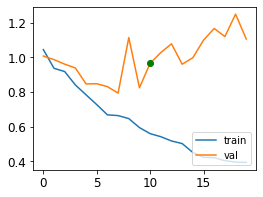

In [23]:
fig = plt.figure()
# plt.title('Loss curves')
plt.plot(train_loss_history, '-', label='train')
plt.plot(val_loss_history, '-', label='val')
idx = len(train_loss_history)- params['patience']
plt.plot(idx, val_loss_history[idx], color='green', marker='o', markersize=6)
# plt.ylim([0.2, 0.9])
plt.legend(loc='lower right')
# plt.xlabel('Iteration')
writer.add_figure(f"Loss curves", fig)
fig

## Testing the Model

As we trained a model and improved it on the validation set, we can now test it on the test set.

In [24]:
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], collate_fn=collate, drop_last=False, num_workers=2)

_, test_acc, test_rmse, y_pred = validation_metrics(model, test_loader)
y_true = [x['label'].item() for x in test_dataset]
report = classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)
print(f"Macro Accuracy: {test_acc}, RMSE: {test_rmse}")
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

writer.add_hparams(params,{"macro_acc":test_acc, "acc": report['accuracy'], "rmse": test_rmse, "f1-score": report['macro avg']['f1-score'],
                         "precision":report['macro avg']['precision'], "recall":report['macro avg']['recall']})
writer.close()

Macro Accuracy: 0.7050325198919088, RMSE: 0.5948743045448419
              precision    recall  f1-score   support

    negative       0.74      0.75      0.74       643
     neutral       0.69      0.54      0.61      1644
    positive       0.69      0.82      0.75      1811

    accuracy                           0.70      4098
   macro avg       0.71      0.71      0.70      4098
weighted avg       0.70      0.70      0.69      4098



## Inference

Now that we trained a sufficiently good sentiment classifier, let's run the below cell and type some text to see some predictions (type exit to quit the demo). Since we used a small data, don't expect too much :).

In [ ]:
text = ''
w2i = vocab
while True:
    text = input()
    if text == 'exit':
        break
    
    words = torch.tensor([
        w2i.get(word, w2i['<unk>'])
        for word in nltk.word_tokenize(text)
    ]).long().to(device).view(-1, 1)  # T x B
    with torch.no_grad():
        pred = model(words).cpu()
        probs = F.softmax(pred, dim=1)
    prob, idx = torch.max(probs, dim=1)
    if idx == 0:
        txt = ':('
    elif idx == 1:
        txt = ':/'
    elif idx == 2:
        txt = ':)'
        
    print('Input text: {}\n'.format(text),
        'Sentiment -> {}, Confidence -> {:.3f}% '.format(txt, *prob*100))
    print()

Input text: awesome but expensive
 Sentiment -> :), Confidence -> 71.865% 

Input text: expensive but awesome
 Sentiment -> :/, Confidence -> 42.852% 

Input text: comfortable place polite staff
 Sentiment -> :/, Confidence -> 75.686% 

Input text: loved it rooms could have been cleaner but food was great
 Sentiment -> :), Confidence -> 84.820% 

Input text: loved it
 Sentiment -> :), Confidence -> 84.636% 

Input text: disgusting rooms, unbearable smell
 Sentiment -> :(, Confidence -> 86.970% 

Input text: totally worth the money, staff helpful, had a great time
 Sentiment -> :), Confidence -> 83.638% 

Input text: kids loved it, great place to rest
 Sentiment -> :), Confidence -> 81.685% 

